# Overview

Check out the outline of how the code works [here](https://colab.research.google.com/drive/1Kd1xH87gH0Wo3x6Rj4G-5P9LQ8Fy1nKC?usp=sharing).

Our image inputs is very similar to [this example](https://github.com/matterport/Mask_RCNN/blob/master/samples/nucleus/nucleus.py) and [this](https://github.com/SriRamGovardhanam/wastedata-Mask_RCNN-multiple-classes/blob/master/final.py), I've copied bits and pieces from both examples so we could use it with OpenImages.  

---


**Changes to base code**:
The images and the masks downloaded from OpenImages are different size, this implementation required both mask and image to have the same dimensions. So I've made changes to `visualize.py`, `utils.py`, `model.py`. Details will be added here later.

---
**before running** add [this](https://drive.google.com/drive/folders/1wx1PyqLcx6R9T8a51i1xjGYqJ4J3jRmw?usp=sharing) folder  by creating a shortcut of the file onto your drive so the directories line up. 


In [1]:
# note

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# the matterport mask rcnn library was last updated 3-4 years ago, older versions
# of some of the dependent libraries will be used instead 
!pip install fiftyone
!pip install h5py==2.10.0

!pip install -U scikit-image==0.16.2

!pip install tensorflow-gpu==1.15.2
!pip install keras==2.1.5

     |████████████████████████████████| 1.2 MB 5.4 MB/s 
     |████████████████████████████████| 79.9 MB 129 kB/s 
     |████████████████████████████████| 29.2 MB 40.5 MB/s 
     |████████████████████████████████| 562 kB 46.2 MB/s 
     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 47.6 MB 91 kB/s 
     |████████████████████████████████| 13.2 MB 19.4 MB/s 
     |████████████████████████████████| 131 kB 45.6 MB/s 
     |████████████████████████████████| 639 kB 43.3 MB/s 
     |████████████████████████████████| 106 kB 44.8 MB/s 
     |████████████████████████████████| 226 kB 48.8 MB/s 
     |████████████████████████████████| 83 kB 1.7 MB/s 
     |████████████████████████████████| 56 kB 4.2 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 78 kB 6.3 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
     |████████████████████████████████| 79 kB 6.7 MB/s 
     |██████████████████████

In [3]:
#Testing if GPU runtime is selected 
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2497571950651292291
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6300704323988562167
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 472944444900030386
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11338832282
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9195468585270402062
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


# Data Preprocessing

We'll access the OpenImages data using `fiftyone` library. Even though we might want, for example, 50 images, all the segmentations and labels that is part of the library are downloaded along with it, e.g if the image contains a picture of a cow and cars, instances of the cars will be listed in the segmentation.csv as well.

So, we need to remove the unwanted information.


In [4]:
import fiftyone as fo
import fiftyone.zoo as foz


In [5]:
!rm -rf /content/SegOpenImage_V6

In [6]:

mammal_list = ['Horse','Monkey','Cattle']

mammals = foz.load_zoo_dataset(
    'open-images-v6',
    splits = ('train','test','validation'),
    max_samples = 200,  #max samples load for each 
    label_types = ['segmentations'],
    classes = mammal_list,
    shuffle=True,
    seed=1,
    dataset_name = 'open-images-v6-mammal',
    dataset_dir = '/content/SegOpenImage_V6'
)

 100% |██████|    4.8Gb/4.8Gb [4.4s elapsed, 0s remaining, 1.1Gb/s]        
 100% |███████████████████| 200/200 [16.2s elapsed, 0s remaining, 11.4 files/s]      
 100% |███████████████████| 200/200 [16.9s elapsed, 0s remaining, 11.2 files/s]      
 100% |███████████████████| 200/200 [15.8s elapsed, 0s remaining, 12.4 files/s]      
Dataset info written to '/content/SegOpenImage_V6/info.json'
Loading 'open-images-v6' split 'train'
 100% |█████████████████| 200/200 [24.4s elapsed, 0s remaining, 8.7 samples/s]       
Loading 'open-images-v6' split 'test'
 100% |█████████████████| 200/200 [17.7s elapsed, 0s remaining, 13.1 samples/s]      
Loading 'open-images-v6' split 'validation'
 100% |█████████████████| 200/200 [13.1s elapsed, 0s remaining, 15.1 samples/s]      
Dataset 'open-images-v6-mammal' created


In [7]:
session = fo.launch_app(mammals)

In [8]:
import pandas as pd
import numpy as np
import os

In [9]:
DATASET_DIR = '/content/SegOpenImage_V6/'

segment_train = pd.read_csv(os.path.join(DATASET_DIR,'train/labels/segmentations.csv'))
segment_test = pd.read_csv(os.path.join(DATASET_DIR,'test/labels/segmentations.csv'))
segment_val = pd.read_csv(os.path.join(DATASET_DIR,'validation/labels/segmentations.csv'))

print('Train set: {} images\n- {} unique ImageIDs  \n- {} masks \n- {} classes'.format(len(os.listdir(os.path.join(DATASET_DIR,'train','data'))),segment_test['ImageID'].nunique(),segment_test['MaskPath'].nunique(),segment_test['LabelName'].nunique()))
print('')
print('Test set: {} images\n- {} unique ImageIDs  \n- {} masks \n- {} classes'.format(len(os.listdir(os.path.join(DATASET_DIR,'test','data'))),segment_test['ImageID'].nunique(),segment_test['MaskPath'].nunique(),segment_test['LabelName'].nunique()))
print('')
print('Validation set: {} images\n- {} unique ImageIDs \n- {} masks \n- {} classes'.format(len(os.listdir(os.path.join(DATASET_DIR,'validation','data'))),segment_val['ImageID'].nunique(),segment_val['MaskPath'].nunique(),segment_val['LabelName'].nunique()))

Train set: 200 images
- 40386 unique ImageIDs  
- 74102 masks 
- 338 classes

Test set: 200 images
- 40386 unique ImageIDs  
- 74102 masks 
- 338 classes

Validation set: 200 images
- 13524 unique ImageIDs 
- 24730 masks 
- 328 classes


## Get class_id for Mammals

In [10]:
# get the LabelName that corresponds to the classes that we want to keep
classes = pd.read_csv(os.path.join(DATASET_DIR,'test/metadata/classes.csv'),names=['LabelName','ClassName'])

class_id = classes[classes['ClassName'].isin(mammal_list)]
class_id.to_csv(os.path.join(DATASET_DIR,'class.csv'))
class_id

LabelName ClassName
114  /m/01xq0k1    Cattle
241    /m/03k3r     Horse
417   /m/08pbxl    Monkey

## Get list of images title

In [11]:
img_train = os.listdir(os.path.join(DATASET_DIR,'train/data'))
img_train = [a[:-4] for a in img_train]

img_test = os.listdir(os.path.join(DATASET_DIR,'test/data'))
img_test = [a[:-4] for a in img_test]

img_val = os.listdir(os.path.join(DATASET_DIR,'validation/data'))
img_val = [a[:-4] for a in img_val]

## Shorten the segmentation files
Include only the data where its mask is part of the class we want and if the images are present in the file


In [12]:
segment_train = segment_train[segment_train['LabelName'].isin(class_id['LabelName'])]
segment_train = segment_train[segment_train['ImageID'].isin(img_train)]

segment_test = segment_test[segment_test['LabelName'].isin(class_id['LabelName'])]
segment_test = segment_test[segment_test['ImageID'].isin(img_test)]

segment_val = segment_val[segment_val['LabelName'].isin(class_id['LabelName'])]
segment_val = segment_val[segment_val['ImageID'].isin(img_val)]


In [13]:
# export as csv into the DATASETDIR
segment_train.to_csv(os.path.join(DATASET_DIR,'train/labels/segment_cut.csv'))
segment_test.to_csv(os.path.join(DATASET_DIR,'test/labels/segment_cut.csv'))
segment_val.to_csv(os.path.join(DATASET_DIR,'validation/labels/segment_cut.csv'))

# Load MaskRCNN and dependencies 

In [40]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import skimage.io
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import imgaug.augmenters as iaa
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import TensorBoard

ROOT_DIR = '/content/drive/MyDrive/final_project/'

In [38]:
!ls '/content/drive/MyDrive/final_project/mrcnn'

config.py    model_resize_mask.py  utils.py		 visualize.py
__init__.py  parallel_model.py	   utils_resize_mask.py
model.py     __pycache__	   visualize_1.py


In [41]:
sys.path.append(ROOT_DIR)
from mrcnn.visualize_1 import display_instances
from mrcnn import visualize_1 as visualize
from mrcnn import model
from mrcnn.model import log
from mrcnn import config
from mrcnn.config import Config
# from mrcnn import model as modellib, utils
from mrcnn import model_resize_mask as modellib
from mrcnn import utils_resize_mask as utils

In [42]:
DATASET_DIR = '/content/SegOpenImage_V6/'
#path to pretrainied COCO weights 
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

#path to fine-tuned weight
model_path = '/content/drive/MyDrive/Mask_RCNN-master/mask_rcnn_mammal_train.h5'



# directory of temporary log
temp_log = '/content/temp_log'


In [43]:
# display preferences
def get_ax(rows=1, cols=1, size=10):
  _,ax = plt.subplots(rows,cols,figsize=(size*cols,size*rows))
  return ax

## Setup Custom Configuration & Dataset Class

In [44]:
DEVICE = '/gpu:0'

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [45]:
class CustomConfig(Config):
  NAME = 'mammal'
  GPU_COUNT = 1

  # 12GB GPU can typical handle 2 images (1024 x 1024)
  # ColabPro High Ram has roughly 27GB GPU
  IMAGES_PER_GPU = 4

  # Background + classes 
  NUM_CLASSES = 1+3

  # Number of training steps per epoch
  STEPS_PER_EPOCH = 50

  # Number of validation steps to runa tt eh end of 
  # every epoch,larger number improves better accuracy
  # but slows down training
  VALIDATION_STEPS = 50

  # ROIs belwo this threshold are skipped
  DETECTION_MIN_CONFIDENCE = .7   
  DETECTION_NMS_THRESHOLD = 0.3
  LEARNING_RATE =0.0005
  BACKBONE = 'resnet101'

  # setting image dimension at a fixed size for all images
  IMAGE_MAX_DIM = 512
  IMAGE_MIN_DIM = 512
  

In [46]:

class CustomDataset(utils.Dataset):
  def load_dataset(self,dataset_dir,subset):
    if subset =='val':
      subset = 'validation'

    classes = pd.read_csv(os.path.join(dataset_dir,'class.csv'))
    dataset_dir = os.path.join(dataset_dir,subset)
    segmentations = pd.read_csv(os.path.join(dataset_dir,'labels/segment_cut.csv'))
   
    dataset_dir = os.path.join(dataset_dir,'data')
    image_ids = [a[:-4] for a in os.listdir(dataset_dir)]


    #subclass_id maps the LabelName in the image to the subclasses were creating
    subclass_id = {}

    #Add subclass into 'mammal' class
    for i in range(len(classes)):
      self.add_class('mammal',i+1,classes.iloc[i]['ClassName'].lower())
      subclass_id[classes.iloc[i]['LabelName'].lower()] = i+1

    for id in image_ids:
      segments = list(segmentations[segmentations['ImageID']==id]['LabelName'])
      subclass_type = [subclass_id[s] for s in segments]

      self.add_image('mammal',
                     image_id = id,
                     subclass = subclass_type,
                     path = os.path.join(dataset_dir,'{}.jpg').format(id))
      
  def load_mask(self,id):
    info = self.image_info[id]

    working_dir = os.path.join(os.path.dirname(os.path.dirname(info['path'])),'labels')

    #gets the first letter of jpg name, that's how masks are stored w OpenImage
    folder = info['id'][0]    
    if folder.isalpha():
      folder = folder.capitalize()

    mask_dir = os.path.join(working_dir,'masks',folder)

    segmentations = pd.read_csv(os.path.join(working_dir,'segment_cut.csv'))
    maskPath = segmentations[segmentations['ImageID']==info['id']]['MaskPath']

    mask = []

    for path in maskPath:
      m = skimage.io.imread(os.path.join(mask_dir,path)).astype(np.bool)
      mask.append(m)

    mask = np.stack(mask, axis=-1)
    subclass_type = np.array(info['subclass'],dtype = np.int32)

    return mask, subclass_type

  def image_reference(self, id):
    info = self.image_info[id]
    if info["source"] == "mammal":
        return info["id"]
    else:
        super(self.__class__, self).image_reference(id)

    

    


## Dataset Inspection

In [47]:
DATASET_DIR

'/content/SegOpenImage_V6/'

In [48]:

config = CustomConfig()
dataset = CustomDataset()

dataset.load_dataset(DATASET_DIR,'train')
dataset.prepare()

In [49]:
# checks our classes
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))



Image Count: 200
Class Count: 4
  0. BG                                                
  1. cattle                                            
  2. horse                                             
  3. monkey                                            


101 (333, 500, 1)


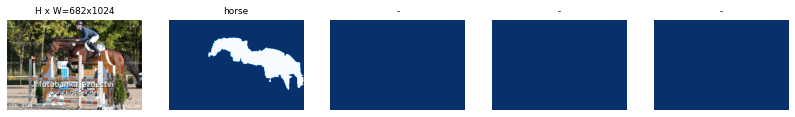

36 (960, 1280, 2)


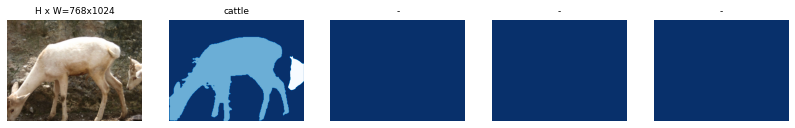

7 (1060, 1600, 4)


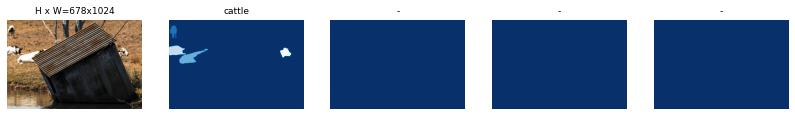

173 (708, 1024, 1)


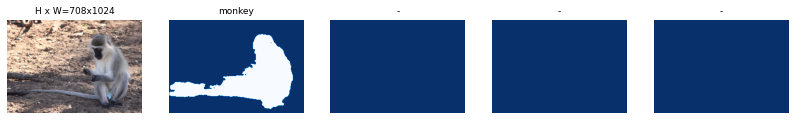

In [50]:
image_ids = np.random.choice(dataset.image_ids,4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    print(image_id,mask.shape)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  31 52478967b11aaa11
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    2.00000  max:    2.00000  int32
bbox                     shape: (1, 4)                min:   87.00000  max:  473.00000  int32


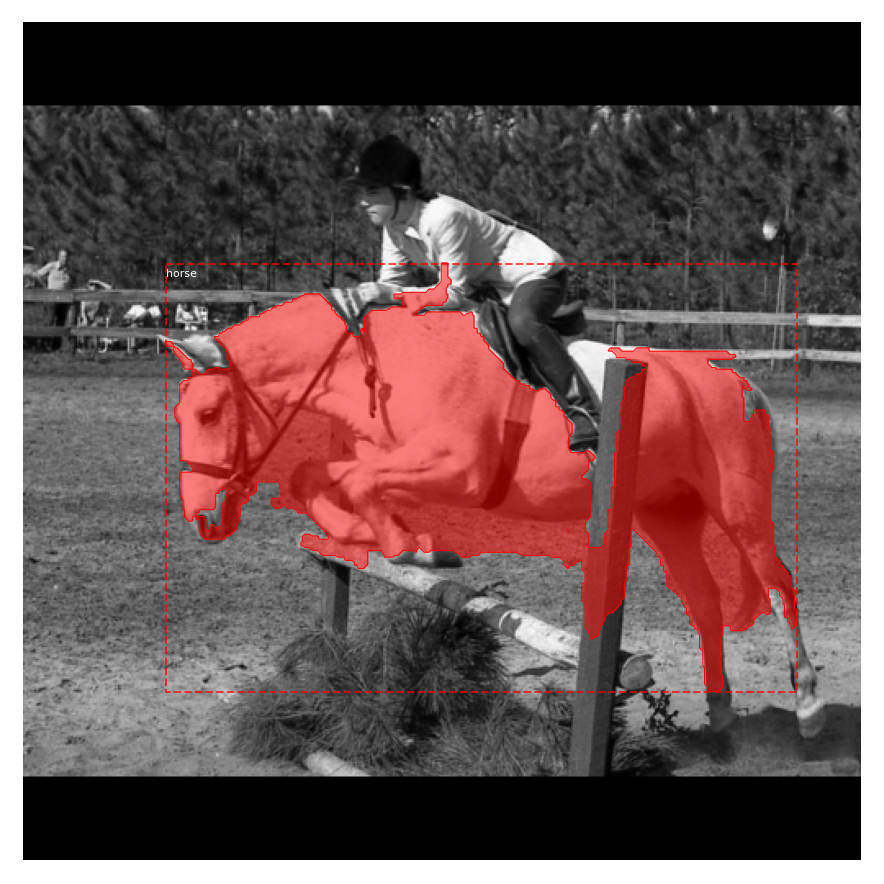

In [51]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids)
image = dataset.load_image(image_id)

mask, class_ids = dataset.load_mask(image_id)

image, window, scale, padding, _ = utils.resize_image(
    image, 
    max_dim=config.IMAGE_MAX_DIM)

mask = utils.resize_mask(mask, image, padding=padding)

# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# # Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
model.log("image", image)
model.log("mask", mask)
model.log("class_ids", class_ids)
model.log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)


image                    shape: (512, 512, 3)         min:    0.00000  max:  217.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max: 1024.00000  float64
class_ids                shape: (2,)                  min:    3.00000  max:    3.00000  int32
bbox                     shape: (2, 4)                min:  164.00000  max:  410.00000  int32
mask                     shape: (512, 512, 2)         min:    0.00000  max:    1.00000  bool


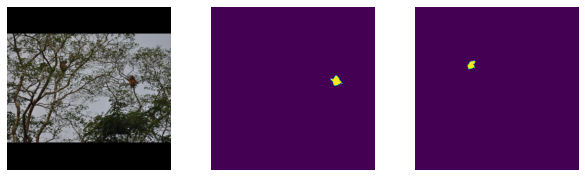

In [52]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

visualize.display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

## Create Model


In [53]:
# laoding training and validaiton
config = CustomConfig()
config.display()

dataset = CustomDataset()
dataset.load_dataset(DATASET_DIR,'train')
dataset.prepare()

val_set = CustomDataset()
val_set.load_dataset(DATASET_DIR,'val')
val_set.prepare()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0005
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

## Training


### Training head

[custom callbacks]https://stackoverflow.com/questions/59875285/set-up-tensorboard-on-matterport-mask-rcnn

### **Why are val losses flunctuating so much?**
Possible answers:
* Learning rate is too high [[1]](https://github.com/matterport/Mask_RCNN/issues/2545)
* Validation set is not representative of whole dataset [[1]](https://github.com/matterport/Mask_RCNN/issues/2545)

In [56]:

temp_log = '/content/temp_log'
model = modellib.MaskRCNN(mode='training',config=config, model_dir=temp_log)

# can either use COCO_MODEL_PATH  
# or use file ive been training file in ROOT_DIR/

model_path = '/content/drive/MyDrive/final_project/mask_rcnn_coco.h5'


In [57]:
# not sure why we need to exclude
model.load_weights(model_path, by_name=True, 
                   exclude=['mrcnn_class_logits','mrcnn_bbox_fc','mrcnn_bbox','mrcnn_mask'])


From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:167: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.


From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:179: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.


From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:183: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.


From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:192: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.


From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:199: The name tf.varia

In [58]:
model.train(dataset, val_set,
            learning_rate= 0.001,
            #config.LEARNING_RATE,
            epochs=10,
            layers='heads',
            # augmentation = iaa.Sequential([ 
            #     iaa.Fliplr(1), 
            #     iaa.Flipud(1), 
            #     iaa.Affine(rotate=(-45, 45)), 
            #     iaa.Affine(rotate=(-90, 90)), 
            #     iaa.Affine(scale=(0.5, 1.5))]),
            custom_callbacks = [tf.keras.callbacks.TensorBoard(
                                  log_dir=os.path.join(ROOT_DIR,'events'),
                                  histogram_freq=0,
                                  write_graph=True,
                                  write_images=False)]
            )

#save weights manually
model_path = os.path.join(ROOT_DIR, "mask_rcnn_mammal_train.h5")
model.keras_model.save_weights(model_path)


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/temp_log/mammal20211219T1808/mask_rcnn_mammal_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4     

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:976: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.


From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:963: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.


From /usr/local/lib/python3.7/dist-packages/keras/callbacks.py:774: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.


From /usr/local/lib/python3.7/dist-packages/keras/callbacks.py:777: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.

Epoch 1/10
50/50 [==============================] - 206s 4s/step - loss: 1.6794 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.2678 - mrcnn_class_loss: 0.2737 - mrcnn_bbox_loss: 0.6688 - mrcnn_mask_loss: 0.4424 - val_loss: 1.0448 - val_rpn_class_loss: 0.0127 - val_rpn_bbox_loss: 0.2108 - val_mrcnn_class_loss: 0.0742 - val_mrcnn_bbox_loss

In [ ]:
model.load_weights(model_path, by_name=True)
model.train(dataset, val_set,
            learning_rate= config.LEARNING_RATE,
            epochs=300,
            layers='all',
            # augmentation = iaa.Sequential([ 
            #     iaa.Fliplr(1), 
            #     iaa.Flipud(1), 
            #     iaa.Affine(rotate=(-45, 45)), 
            #     iaa.Affine(rotate=(-90, 90)), 
            #     iaa.Affine(scale=(0.5, 1.5))]),
            custom_callbacks = [tf.keras.callbacks.TensorBoard(
                                  log_dir=os.path.join(ROOT_DIR,'events'),
                                  histogram_freq=0,
                                  write_graph=True,
                                  write_images=False)]
            )

#save weights manually
model_path = os.path.join(ROOT_DIR, "mask_rcnn_mammal_train.h5")
model.keras_model.save_weights(model_path)

In [73]:
!ls /content/drive/MyDrive/final_project/Experimentation/


 12012021   12042021   12102021   12112021_2   12132021  '12192021 (1)'
 12022021   12092021   12112021   12122021     12142021   Original


In [71]:
!cp /content/temp_log/mammal20211219T1808/mask_rcnn_mammal_0010.h5 "/content/drive/MyDrive/final_project/Experimentation/12192021/"

In [75]:
!cp /content/temp_log/mammal20211219T1808/events.out.tfevents.1639937351.999d6dda7416 "/content/drive/MyDrive/final_project/Experimentation/12192021/"

## Visualizing & Understanding Losses
* [StackOverflow](https://stackoverflow.com/questions/55360262/what-exactly-are-the-losses-in-matterport-mask-r-cnn)
* [Medium](https://medium.com/analytics-vidhya/taming-the-hyper-parameters-of-mask-rcnn-3742cb3f0e1b)
* [Code comments](https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/model.py)
* [Paper](https://arxiv.org/pdf/1703.06870.pdf)





In [61]:
tf_file = os.path.dirname(model.find_last())

In [62]:
%reload_ext tensorboard

In [63]:
%tensorboard --logdir /content/drive/MyDrive/final_project/Experimentation/

Output hidden; open in https://colab.research.google.com to view.

In [64]:
class InferenceConfig(CustomConfig):
  GPU_COUNT =1 
  IMAGES_PER_GPU = 1
  DETECTION_MIN_CONFIDENCE = .5

inference_config = InferenceConfig()
model = modellib.MaskRCNN(mode = 'inference',
                          config = inference_config,
                          model_dir=temp_log)

#get last saved weights

model_path = '/content/drive/MyDrive/final_project/mask_rcnn_mammal_train.h5'

#load trained weights
model.load_weights(model_path, by_name=True)


From /content/drive/MyDrive/final_project/mrcnn/model_resize_mask.py:720: The name tf.sets.set_intersection is deprecated. Please use tf.sets.intersection instead.


From /content/drive/MyDrive/final_project/mrcnn/model_resize_mask.py:722: The name tf.sparse_tensor_to_dense is deprecated. Please use tf.sparse.to_dense instead.

Instructions for updating:
Use `tf.cast` instead.
From /content/drive/MyDrive/final_project/mrcnn/model_resize_mask.py:772: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    3.00000  max:    3.00000  int32
gt_bbox                  shape: (1, 4)                min:  211.00000  max:  359.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool


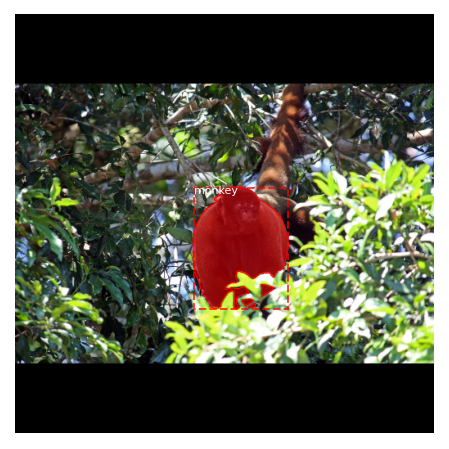

In [76]:
image_id = np.random.choice(val_set.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(val_set, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


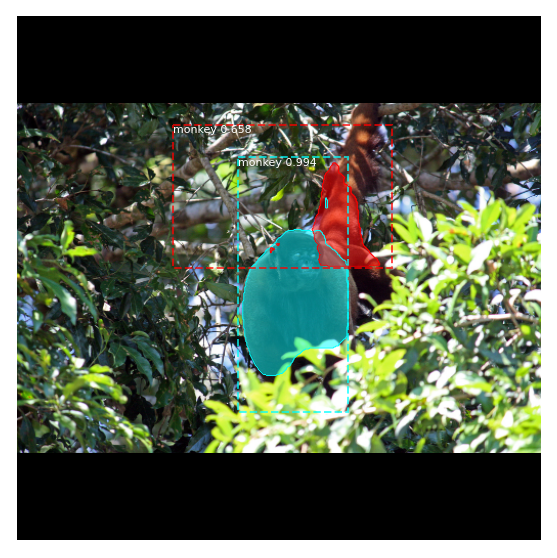

In [77]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            val_set.class_names, r['scores'], ax=get_ax())

image ID: mammal.013c1912b07046b8 (86) 013c1912b07046b8
Original image shape:  [ 682 1024    3]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
gt_class_id              shape: (2,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (2, 4)                min:   76.00000  max:  512.00000  int32
gt_mask                  shape: (512, 512, 2)         min:    0.00000  max:    1.00000  bool
AP @0.50:	 1.000
AP @0.55:	 1.000
AP @0.60:	 1.000
AP @0.65:	 1.000
AP @0.70:	 0.500
AP @0.75:	 0.500
AP @0.80:	 0.500
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 0.550


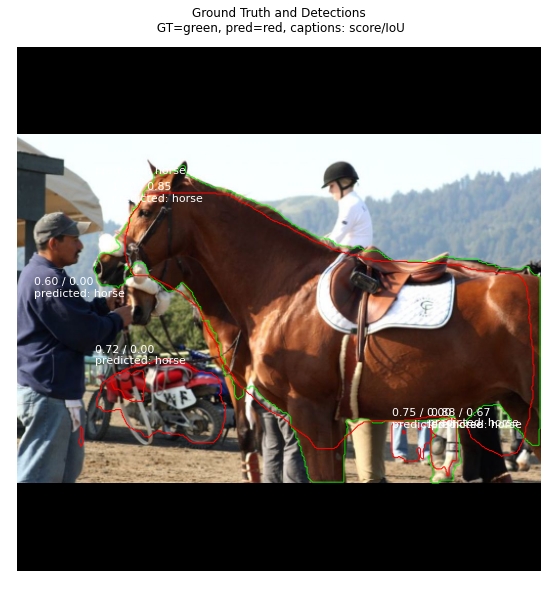

In [78]:
image_id = np.random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

## Precision recall

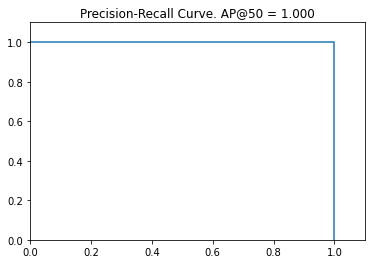

In [79]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

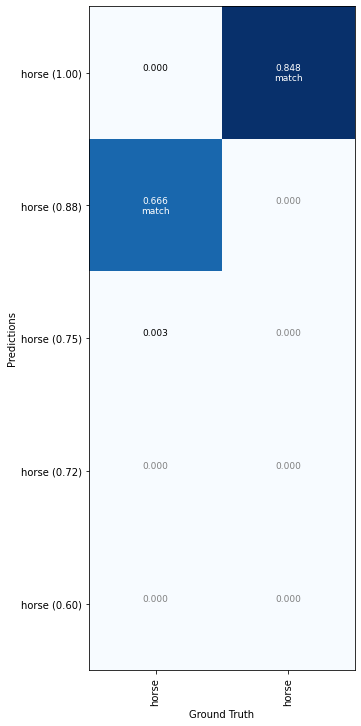

In [80]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

In [81]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 10)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

mAP @ IoU=50:  0.8822115395218134


In [ ]:
while True:pass